In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
 
# Set a random seed for reproducibility
np.random.seed(0)
 
# Load your temperature dataset with columns "DATE" and "Temperature"
data = pd.read_csv('DailyDelhiClimateTest.csv')
 
# Make sure your "Date" column is in datetime format
data['date'] = pd.to_datetime(data['date'])
 
# Sorting the data by date (if not sorted)
# data = data.sort_values(by='date')
 
# Resetting the index
data.set_index('date', inplace=True)
 
data.dropna(inplace=True)

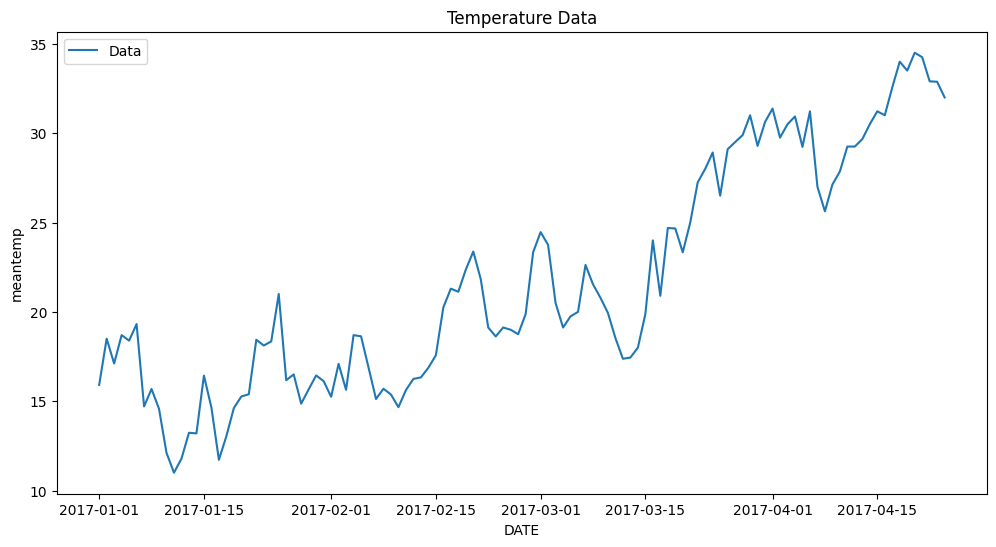

In [25]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot( data['meantemp'], label='Data')
plt.xlabel('DATE')
plt.ylabel('meantemp')
plt.legend()
plt.title('Temperature Data')
plt.show()

In [26]:
data.describe

<bound method NDFrame.describe of              meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900000  40.900000    8.890000   1001.600000
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 4 columns]>

In [27]:
# Adding lag features to the DataFrame
for i in range(1, 8):  # Creating lag features up to 5 days
    data[f'Lag_{i}'] = data['meantemp'].shift(i)
 
# Drop rows with NaN values resulting from creating lag features
data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Reset index for both train and test data
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

 
y_train = train_data['meantemp']
 
y_test = test_data['meantemp']

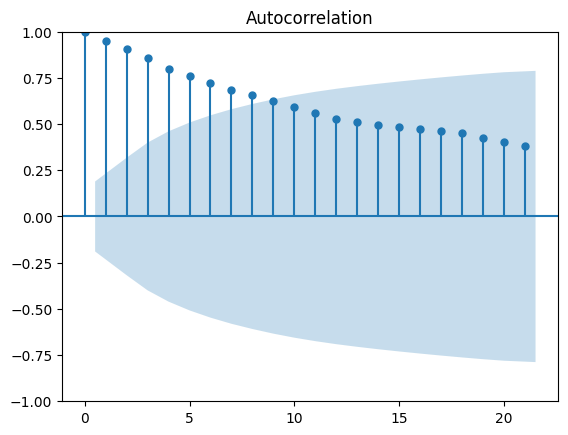

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
series = data['meantemp']
plot_acf(series)
plt.show()

In [29]:
data['meantemp'].corr(data['meantemp'].shift(1))


0.9671785606969336

In [30]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train the autoregressive model
lag_order = 27 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train, lags=lag_order)
ar_results = ar_model.fit()


In [31]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
#print(y_pred)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


Mean Absolute Error: 2.75
Root Mean Squared Error: 3.10


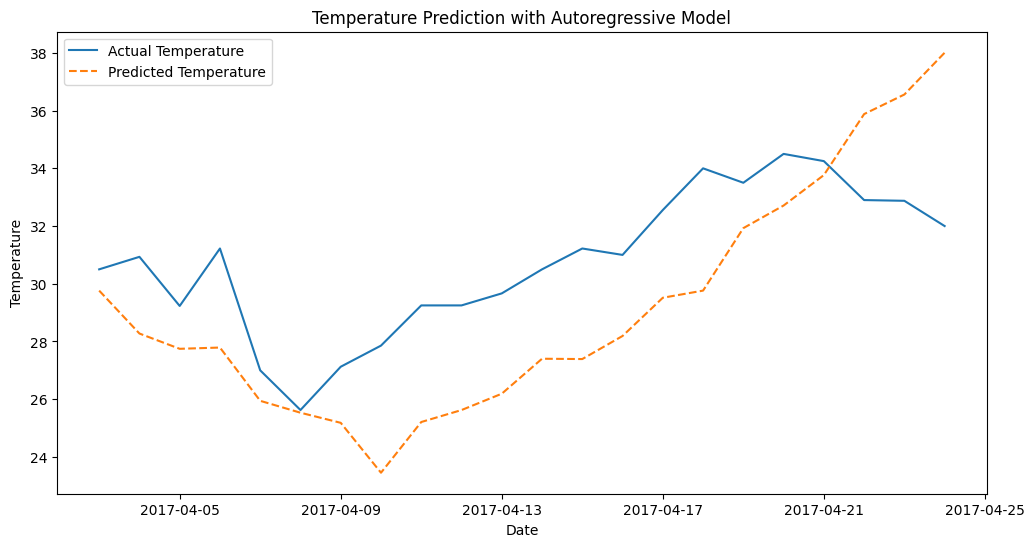

In [32]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data["date"] ,y_test, label='Actual Temperature')
plt.plot( test_data["date"],y_pred, label='Predicted Temperature', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()


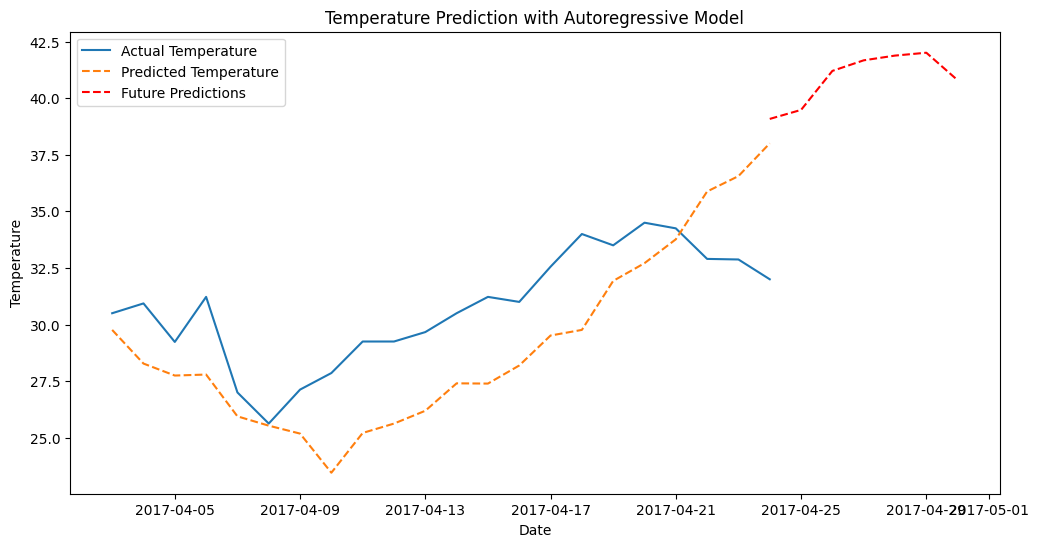

In [33]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps = 7

# Extend the predictions into the future for one year
future_indices = range(len(test_data), len(test_data) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) + forecast_steps - 1, dynamic=False)

# Create date indices for the future predictions
future_dates = pd.date_range(start=test_data['date'].iloc[-1], periods=forecast_steps, freq='D')

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual Temperature')
plt.plot(test_data['date'], y_pred, label='Predicted Temperature', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()
